# Pulse control

In [1]:
from qiskit import *

# Matplotlib is recommended for Qiskit.
import numpy as np
import qutip as qt
import matplotlib.pyplot as plt
%matplotlib inline

# Load account (requires a saved IBMQ user id) and list available backends.
IBMQ.load_account()
provider = IBMQ.get_provider(group='open')
provider.backends()

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_16_melbourne') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_vigo') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_ourense') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_london') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_burlington') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_essex') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_armonk') from IBMQ(hub='ibm-q', group='open', project='main')>]

In [2]:
# Jupyter widget for tracking IBMQ jobs.
import qiskit.tools.jupyter
%qiskit_job_watcher

Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

ibmq_armonk


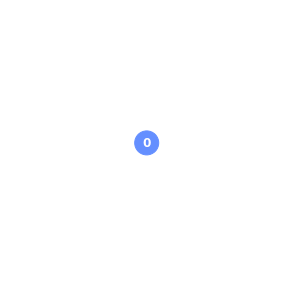

In [4]:
# Backend with right connectivity map for the five-qubit GHZ circuit.
backend = provider.get_backend(open_pulse=True)

# Set qasm as simulator.
simulator = Aer.get_backend('qasm_simulator')

# Print name and configuration of backend.
from qiskit.visualization import plot_gate_map
print(backend)
plot_gate_map(backend)

## Channels

Physical channels on the backend. `Channels` combined with `Commands` form an `Instruction`.

In [43]:
# Delcare the fundamental channels.
from qiskit.pulse.channels import (DriveChannel, MeasureChannel, ControlChannel, 
                                   AcquireChannel, MemorySlot)
drive_ch = DriveChannel(0)
meas_ch = MeasureChannel(0)
ctrl_ch = ControlChannel(0)
acqu_ch = AcquireChannel(0)
mem_sl = MemorySlot(0)

## Commands

Actions that can be completed on a device `Channel`. 

Can be used repeatedly. Some `Commands` are exclusive to specific `Channels`.

In [44]:
# Define a pulse, framechange and acquire.
from qiskit.pulse.commands import (SamplePulse, FrameChange, Acquire)
sine_pulse = SamplePulse(np.sin(np.linspace(0, 4*np.pi, 21)), name='sine_pulse')
pi_frame = FrameChange(np.pi, name='pi_frame')
acquire = Acquire(100, name='acquire')

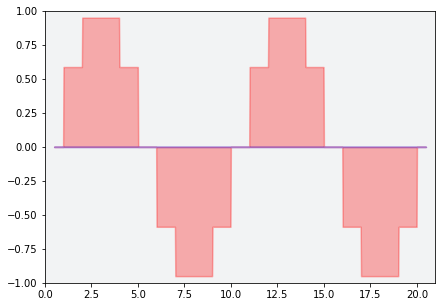

In [45]:
sine_pulse.draw()

## Instruction

Created by applying a `Command` to a `Channel`.

Each `Command` has a corresponding `Instruction` type.

In [49]:
# Create an instruction.
sine_inst = sine_pulse(drive_ch) # or sine_pulse.to_instruction(drive_ch)
acqu_inst = acquire(acqu_ch, mem_sl)

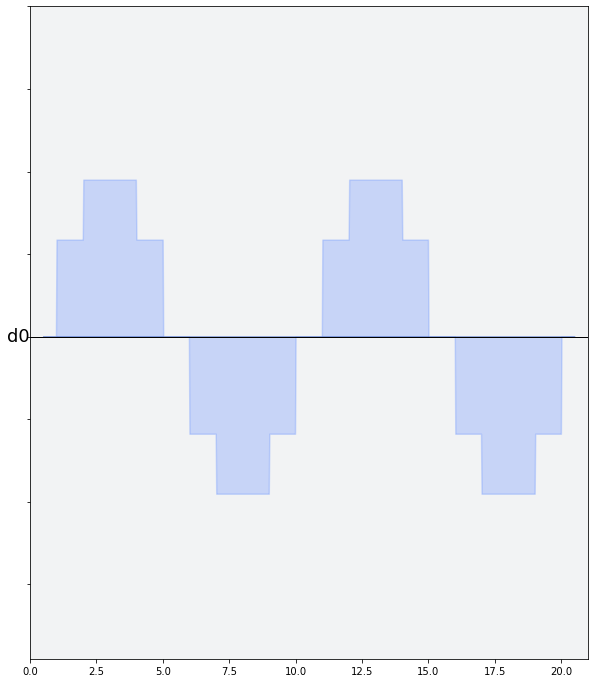

In [52]:
sine_inst.draw()

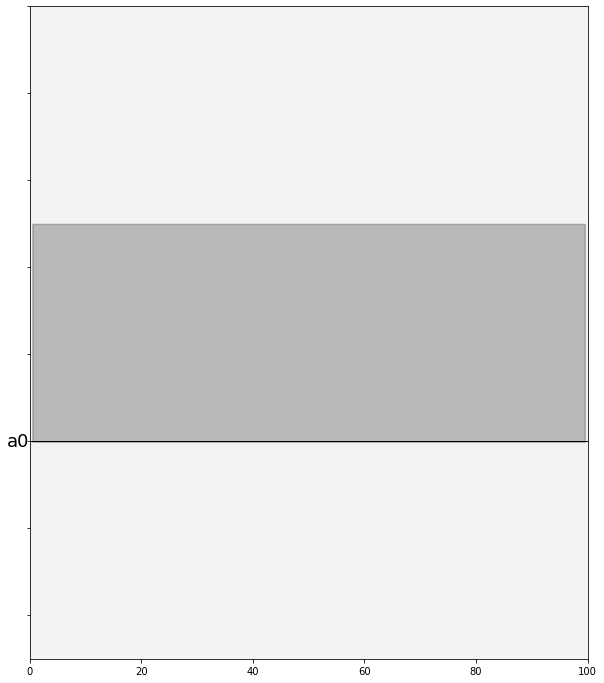

In [54]:
acqu_inst.draw()

## Schedules

Set of `Instructions` executed at specific times. 

`Schedules` can contain `schedules`.

Can be modified by doing `unions`, `shifts` and `appends`.

In [67]:
# Two unit schedules to pulse and acquire.
from qiskit.pulse import pulse_lib, Schedule
sine_sched = Schedule(sine_inst, name='sine_sched')
acqu_sched = Schedule((10, acqu_inst), name='acqu_sched')

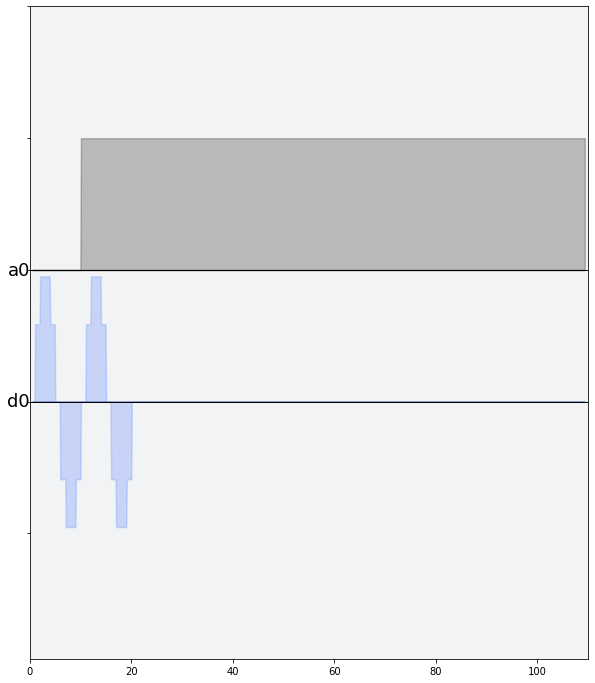

In [68]:
union_sched = sine_sched.union(acqu_sched)
union_sched.draw()

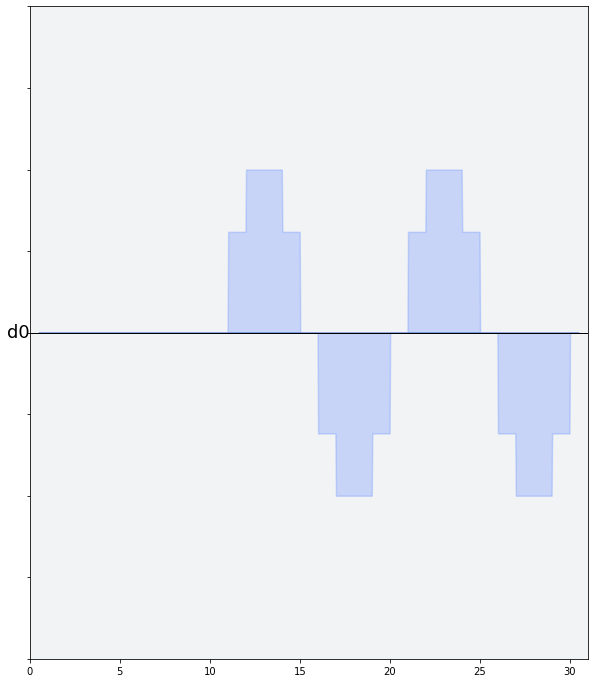

In [69]:
shift_sched = sine_sched.shift(10)
shift_sched.draw()

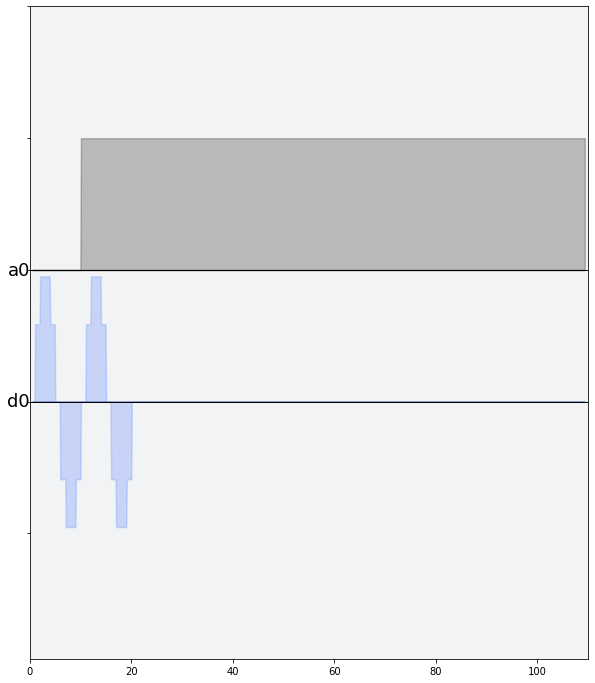

In [70]:
append_sched = sine_sched.append(acqu_sched)
append_sched.draw()

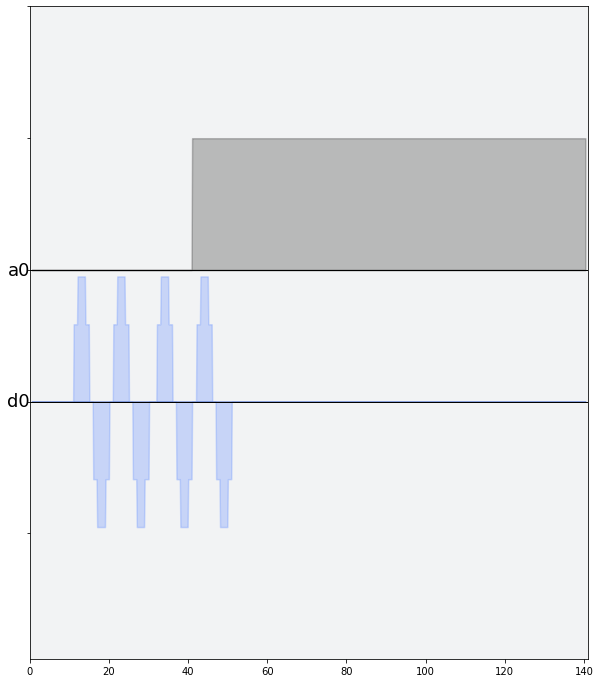

In [87]:
# Syntactic sugar, baby. 
# Can make schedules directly from instructions.
sched = Schedule(name='syntax_test')
sched |= sine_sched << 10
sched += acqu_sched + sine_sched
sched.draw()

In [93]:
from qiskit.qobj.utils import MeasLevel, MeasReturnType
job = execute(sched, backend, meas_level=MeasLevel.CLASSIFIED, 
              meas_return=MeasReturnType.AVERAGE, shots=1000)

/Users/thomassmith/anaconda3/lib/python3.7/site-packages/qiskit/providers/models/pulsedefaults.py:155: UserWarning: `qubit_freq_est` and `meas_freq_est` now have units of Hertz(Hz) rather than gigahertz(GHz).
  warnings.warn('`qubit_freq_est` and `meas_freq_est` now have units of '
/Users/thomassmith/anaconda3/lib/python3.7/site-packages/qiskit/providers/models/backendconfiguration.py:377: UserWarning: `rep_time` now has units of seconds(s) rather than microseconds(mu s).
  warnings.warn('`rep_time` now has units of seconds(s) rather '


In [95]:
job = execute(sched, backend, meas_level=2)
result = job.result()

IBMQJobFailureError: 'Unable to retrieve job result. Job has failed. Use job.error_message() to get more details.'

In [96]:
job.error_message()

'Internal Error. Error code: 9322.'